# Sentiment Analysis - Shopee & Tokopedia Review Classification

Notebook ini melakukan klasifikasi rating (1-5) berdasarkan teks review produk dari Shopee dan Tokopedia menggunakan metode sederhana.

In [10]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

## 1. Load and Explore Dataset

In [11]:
# Load the dataset with a different encoding
df = pd.read_csv("./review_product_di_shoppe_dan_tokopedia.csv", delimiter=';', encoding='latin1')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
display(df.head())

print("\nRating Distribution:")
print(df['rating'].value_counts().sort_index())

Dataset Shape: (68346, 3)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68346 entries, 0 to 68345
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  68346 non-null  int64 
 1   review     68041 non-null  object
 2   rating     68346 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ MB
None

First 5 rows:


,review_id,review,rating
0,0,slow delivery,1
1,1,Dateng goods do not conform pesanan??,1
2,2,PSN k its 20 other DTG,1
3,3,I am expected that it have a frame and painted...,1
4,4,The product quality is not good.,1



Rating Distribution:
rating
1     6404
2     5501
3    15536
4    18240
5    22665
Name: count, dtype: int64


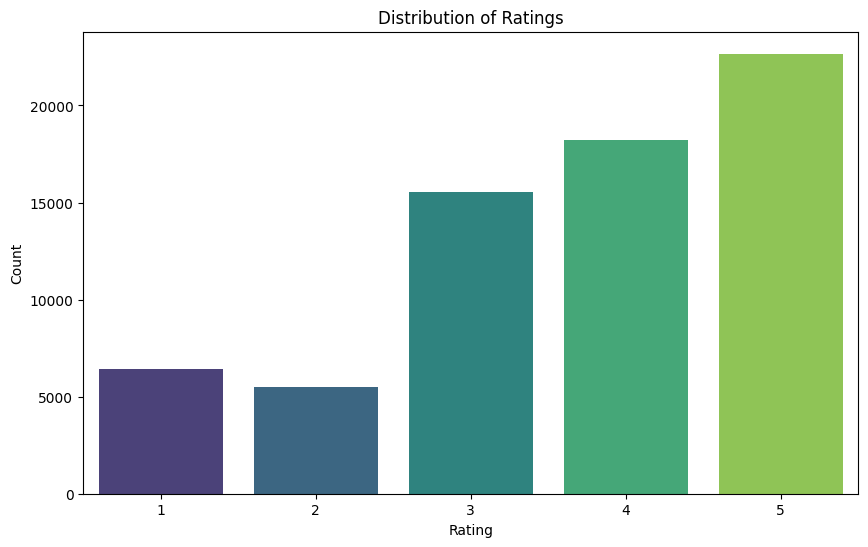

Missing values:
review_id      0
review       305
rating         0
dtype: int64


In [12]:
# Visualize rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

In [13]:
# Calculate the proportion of missing values
missing_proportion = df.isnull().mean()
print("Proportion of missing values:")
print(missing_proportion)

# Drop rows with missing values
df = df.dropna().reset_index(drop=True)
print(f"\nDataset shape after dropping missing values: {df.shape}")

Proportion of missing values:
review_id    0.000000
review       0.004463
rating       0.000000
dtype: float64

Dataset shape after dropping missing values: (68041, 3)


## 2. Text Preprocessing

Membersihkan dan memproses teks review untuk persiapan modeling.

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# Download necessary NLTK data
try:
    nltk.download('punkt')
    nltk.download('stopwords')
except:
    pass

# Initialize stopwords and stemmer
try:
    stop_words = set(stopwords.words('english'))
except:
    stop_words = set(['a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'will', 'with'])

stemmer = PorterStemmer()

def advanced_clean_text(text):
    """
    Enhanced text cleaning function
    """
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters but keep important punctuation for sentiment
    text = re.sub(r'[^a-zA-Z\s!?.]', ' ', text)
    
    # Handle negations (important for sentiment)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    
    # Handle repeated characters (e.g., "gooood" -> "good")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Tokenize
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()
    
    # Remove very short words (less than 2 characters) and stopwords
    cleaned_tokens = []
    for word in tokens:
        if len(word) > 1 and word not in stop_words:
            # Apply stemming
            try:
                stemmed_word = stemmer.stem(word)
                cleaned_tokens.append(stemmed_word)
            except:
                cleaned_tokens.append(word)
    
    return ' '.join(cleaned_tokens)

# Apply enhanced text cleaning
print("Applying enhanced text preprocessing...")
df['cleaned_review'] = df['review'].apply(advanced_clean_text)

# Remove empty reviews and very short reviews (less than 3 words)
df = df[df['cleaned_review'].str.len() > 0].reset_index(drop=True)
df = df[df['cleaned_review'].str.split().str.len() >= 3].reset_index(drop=True)

print(f"Dataset shape after enhanced cleaning: {df.shape}")
print("\nExample of enhanced cleaned text:")
for i in range(3):
    print(f"Original: {df['review'].iloc[i]}")
    print(f"Cleaned:  {df['cleaned_review'].iloc[i]}")
    print("-" * 70)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bangjhener/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bangjhener/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Applying enhanced text preprocessing...
Dataset shape after enhanced cleaning: (63225, 4)

Example of enhanced cleaned text:
Original: Dateng goods do not conform pesanan??
Cleaned:  dateng good conform pesanan
----------------------------------------------------------------------
Original: I am expected that it have a frame and painted in a canvass but sad to note i am very disappointed. It printed like a tarp.! I will not suggest this seller and recommend. So disappointed.
Cleaned:  expect frame paint canvass sad note disappoint print like tarp. suggest seller recommend disappoint
----------------------------------------------------------------------
Original: The product quality is not good.
Cleaned:  product qualiti good
----------------------------------------------------------------------
Dataset shape after enhanced cleaning: (63225, 4)

Example of enhanced cleaned text:
Original: Dateng goods do not conform pesanan??
Cleaned:  dateng good conform pesanan
-----------------------

## 3. Feature Extraction dengan TF-IDF

Mengkonversi teks menjadi fitur numerik menggunakan TF-IDF Vectorizer.

In [15]:
# Check class distribution
print("Class distribution:")
print(df['rating'].value_counts().sort_index())
print("\nClass proportions:")
print(df['rating'].value_counts(normalize=True).sort_index())

# Prepare features and target
X = df['cleaned_review']
y = df['rating']

# Split the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Enhanced TF-IDF vectorizer with better parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Increased features
    ngram_range=(1, 3),  # Include trigrams
    min_df=3,  # Minimum document frequency
    max_df=0.90,  # Maximum document frequency
    stop_words='english',  # Remove English stop words
    sublinear_tf=True,  # Apply sublinear tf scaling
    norm='l2',  # L2 normalization
    lowercase=True
)

# Fit and transform training data
print("\nCreating TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Save the enhanced TF-IDF vectorizer
import os
os.makedirs('model', exist_ok=True)
joblib.dump(tfidf_vectorizer, 'model/enhanced_tfidf_vectorizer.pkl')
print("Enhanced TF-IDF vectorizer saved as 'model/enhanced_tfidf_vectorizer.pkl'")

Class distribution:
rating
1     5840
2     5053
3    14808
4    17161
5    20363
Name: count, dtype: int64

Class proportions:
rating
1    0.092369
2    0.079921
3    0.234211
4    0.271427
5    0.322072
Name: proportion, dtype: float64

Training set size: 50580
Test set size: 12645

Creating TF-IDF features...
TF-IDF feature matrix shape: (50580, 1000)
TF-IDF feature matrix shape: (50580, 1000)
Enhanced TF-IDF vectorizer saved as 'model/enhanced_tfidf_vectorizer.pkl'
Enhanced TF-IDF vectorizer saved as 'model/enhanced_tfidf_vectorizer.pkl'


## 4. Machine Learning Models

Melatih beberapa model sederhana untuk klasifikasi sentiment.

In [16]:
# Import additional models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

# Initialize enhanced models with better parameters
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        C=1.0,
        class_weight='balanced'  # Handle class imbalance
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    # 'Gradient Boosting': GradientBoostingClassifier(
    #     n_estimators=100,
    #     learning_rate=0.1,
    #     max_depth=6,
    #     random_state=42
    # ),
    'SGD Classifier': SGDClassifier(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    )
}

# Add XGBoost if available
try:
    models['XGBoost'] = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='mlogloss'
    )
except:
    print("XGBoost not available, skipping...")

# Train and evaluate models
results = {}
print("Training enhanced models...")

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    
    try:
        # Train model
        model.fit(X_train_tfidf, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_tfidf)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred
        }
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        continue

# Find best model
if results:
    best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_model = results[best_model_name]['model']
    best_accuracy = results[best_model_name]['accuracy']

    print(f"\n{'='*60}")
    print(f"BEST MODEL: {best_model_name}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print(f"{'='*60}")
else:
    print("No models were successfully trained!")

Training enhanced models...

Training Logistic Regression...
Accuracy: 0.4592

Classification Report:
              precision    recall  f1-score   support

           1       0.42      0.69      0.53      1168
           2       0.28      0.46      0.35      1010
           3       0.55      0.50      0.53      2962
           4       0.43      0.53      0.47      3432
           5       0.57      0.31      0.40      4073

    accuracy                           0.46     12645
   macro avg       0.45      0.50      0.45     12645
weighted avg       0.49      0.46      0.46     12645


Training Naive Bayes...
Accuracy: 0.4680

Classification Report:
              precision    recall  f1-score   support

           1       0.45      0.62      0.52      1168
           2       0.44      0.21      0.28      1010
           3       0.48      0.61      0.53      2962
           4       0.43      0.51      0.47      3432
           5       0.52      0.36      0.42      4073

    accuracy     

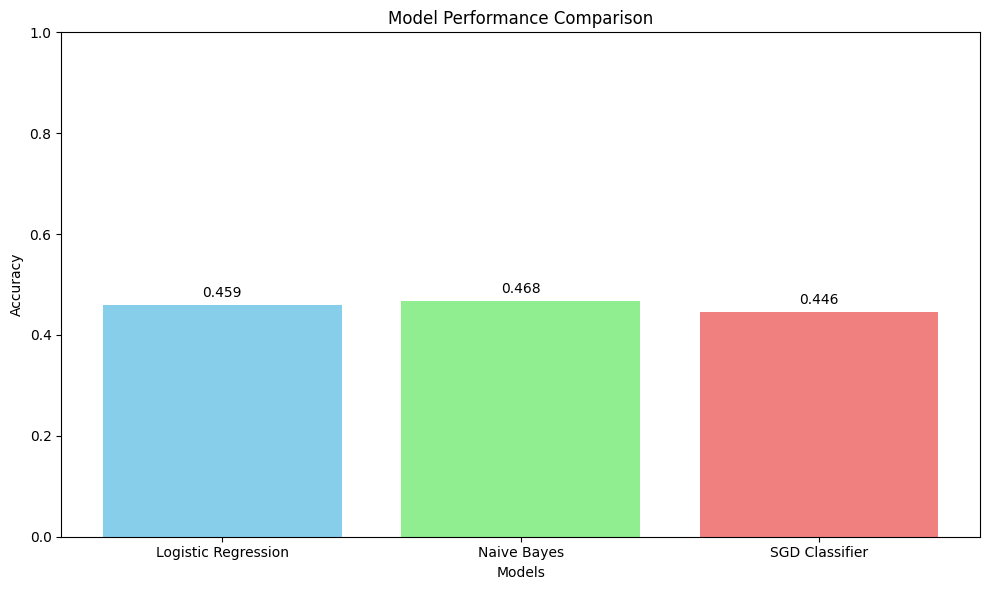

In [17]:
# Visualize model performance
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

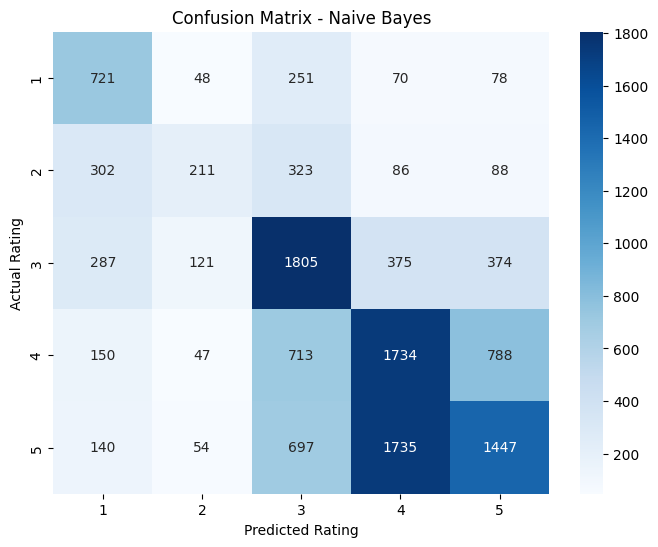

In [18]:
# Confusion Matrix for best model
best_predictions = results[best_model_name]['predictions']

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5], 
            yticklabels=[1, 2, 3, 4, 5])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

## 5. Model Saving

Menyimpan model terbaik dan preprocessing components untuk deployment.

In [19]:
# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

if 'best_model' in locals():
    # Save the best model
    joblib.dump(best_model, f'models/enhanced_sentiment_model_{best_model_name.lower().replace(" ", "_")}.pkl')
    print(f"Best model ({best_model_name}) saved as 'models/enhanced_sentiment_model_{best_model_name.lower().replace(' ', '_')}.pkl'")

    # Save enhanced text cleaning function
    joblib.dump(advanced_clean_text, 'models/enhanced_text_cleaner.pkl')
    print("Enhanced text cleaning function saved as 'models/enhanced_text_cleaner.pkl'")

    # Save model metadata
    model_info = {
        'best_model_name': best_model_name,
        'best_accuracy': best_accuracy,
        'feature_count': X_train_tfidf.shape[1],
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'preprocessing': 'enhanced',
        'tfidf_params': {
            'max_features': 10000,
            'ngram_range': (1, 3),
            'min_df': 3,
            'max_df': 0.90
        }
    }

    joblib.dump(model_info, 'models/enhanced_model_info.pkl')
    print("Enhanced model information saved as 'models/enhanced_model_info.pkl'")

    print(f"\nEnhanced Model Summary:")
    print(f"- Best Model: {best_model_name}")
    print(f"- Accuracy: {best_accuracy:.4f}")
    print(f"- Features: {X_train_tfidf.shape[1]}")
    print(f"- Training Samples: {len(X_train)}")
    print(f"- Test Samples: {len(X_test)}")
    print(f"- Preprocessing: Enhanced with negation handling, stemming, and better cleaning")
else:
    print("No best model available to save!")

Best model (Naive Bayes) saved as 'models/enhanced_sentiment_model_naive_bayes.pkl'
Enhanced text cleaning function saved as 'models/enhanced_text_cleaner.pkl'
Enhanced model information saved as 'models/enhanced_model_info.pkl'

Enhanced Model Summary:
- Best Model: Naive Bayes
- Accuracy: 0.4680
- Features: 1000
- Training Samples: 50580
- Test Samples: 12645
- Preprocessing: Enhanced with negation handling, stemming, and better cleaning


In [20]:
# Save models for Streamlit integration
import os
os.makedirs('model', exist_ok=True)

if 'best_model' in locals() and 'tfidf_vectorizer' in locals():
    # Save the best model with consistent naming for streamlit
    joblib.dump(best_model, 'model/sentiment_model.pkl')
    print("Sentiment model saved as 'model/sentiment_model.pkl'")
    
    # Save TF-IDF vectorizer for streamlit
    joblib.dump(tfidf_vectorizer, 'model/tfidf_vectorizer.pkl') 
    print("TF-IDF vectorizer saved as 'model/tfidf_vectorizer.pkl'")
    
    # Save the advanced text cleaner function
    joblib.dump(advanced_clean_text, 'model/text_cleaner.pkl')
    print("Text cleaner saved as 'model/text_cleaner.pkl'")
    
    print(f"\nStreamlit Integration Ready!")
    print(f"- Sentiment Model: model/sentiment_model.pkl")
    print(f"- TF-IDF Vectorizer: model/tfidf_vectorizer.pkl") 
    print(f"- Text Cleaner: model/text_cleaner.pkl")
    print(f"- Best Model: {best_model_name} with accuracy: {best_accuracy:.4f}")
else:
    print("Models not available. Please run training cells first.")

Sentiment model saved as 'model/sentiment_model.pkl'
TF-IDF vectorizer saved as 'model/tfidf_vectorizer.pkl'
Text cleaner saved as 'model/text_cleaner.pkl'

Streamlit Integration Ready!
- Sentiment Model: model/sentiment_model.pkl
- TF-IDF Vectorizer: model/tfidf_vectorizer.pkl
- Text Cleaner: model/text_cleaner.pkl
- Best Model: Naive Bayes with accuracy: 0.4680
TF-IDF vectorizer saved as 'model/tfidf_vectorizer.pkl'
Text cleaner saved as 'model/text_cleaner.pkl'

Streamlit Integration Ready!
- Sentiment Model: model/sentiment_model.pkl
- TF-IDF Vectorizer: model/tfidf_vectorizer.pkl
- Text Cleaner: model/text_cleaner.pkl
- Best Model: Naive Bayes with accuracy: 0.4680


## 6. Testing dan Prediksi

Testing model dengan contoh review baru.

In [21]:
# Enhanced function to predict sentiment of new reviews
def predict_sentiment_enhanced(review_text, model, vectorizer, cleaner):
    """
    Predict sentiment rating for a new review using enhanced preprocessing
    """
    # Clean the text
    cleaned_text = cleaner(review_text)
    
    # Check if text is empty after cleaning
    if not cleaned_text or len(cleaned_text.strip()) == 0:
        return 3, [0.0, 0.0, 1.0, 0.0, 0.0]  # Return neutral if no text
    
    # Transform to TF-IDF
    text_tfidf = vectorizer.transform([cleaned_text])
    
    # Make prediction
    prediction = model.predict(text_tfidf)[0]
    
    # Get probability if available
    try:
        probability = model.predict_proba(text_tfidf)[0]
    except:
        # If predict_proba is not available, create dummy probabilities
        probability = [0.0] * 5
        probability[prediction - 1] = 1.0
    
    return prediction, probability

# Test with more diverse sample reviews
test_reviews = [
    "This product is absolutely amazing! Outstanding quality and lightning fast delivery. Highly recommended to everyone!",
    "Terrible product. Completely disappointed with the poor quality. Will never buy again. Waste of money!",
    "Product is okay, nothing extraordinary but acceptable for the price point.",
    "Excellent service! Product arrived quickly and in perfect condition. Very satisfied with my purchase!",
    "Bad experience overall. Product was damaged during shipping and seller was completely unresponsive.",
    "Good quality product but delivery was slow. Overall satisfied.",
    "Not bad, could be better. Average quality for average price.",
    "Love it! Exactly what I expected. Fast shipping and great packaging.",
    "Disappointed with quality. Product looks different from photos.",
    "Perfect! Best purchase ever. Highly recommend this seller!"
]

if 'best_model' in locals():
    print("Testing Enhanced Model with Sample Reviews:")
    print("=" * 70)

    for i, review in enumerate(test_reviews, 1):
        predicted_rating, probabilities = predict_sentiment_enhanced(
            review, best_model, tfidf_vectorizer, advanced_clean_text
        )
        
        print(f"\nTest Review {i}:")
        print(f"Text: {review}")
        print(f"Predicted Rating: {predicted_rating}")
        print(f"Confidence: {max(probabilities):.3f}")
        
        # Show top 2 most likely ratings
        prob_dict = dict(zip(range(1, 6), probabilities))
        sorted_probs = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
        print(f"Top predictions: {sorted_probs[:2]}")
        print("-" * 70)
else:
    print("No trained model available for testing!")

Testing Enhanced Model with Sample Reviews:

Test Review 1:
Text: This product is absolutely amazing! Outstanding quality and lightning fast delivery. Highly recommended to everyone!
Predicted Rating: 4
Confidence: 0.473
Top predictions: [(4, 0.4730997799607963), (5, 0.454060550974035)]
----------------------------------------------------------------------

Test Review 2:
Text: Terrible product. Completely disappointed with the poor quality. Will never buy again. Waste of money!
Predicted Rating: 1
Confidence: 0.913
Top predictions: [(1, 0.9130891810529764), (2, 0.07155611645851792)]
----------------------------------------------------------------------

Test Review 3:
Text: Product is okay, nothing extraordinary but acceptable for the price point.
Predicted Rating: 3
Confidence: 0.311
Top predictions: [(3, 0.31079985007741406), (1, 0.2320150501730089)]
----------------------------------------------------------------------

Test Review 4:
Text: Excellent service! Product arrived quickl